<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">Màster universitari en Ciència de dades (Data Science)</p>
<p style="margin: 0; text-align:right;">M2.982 Treball final de màster · Àrea 5 · Any 2020</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Predicción de consumos eléctricos · Carles Figuera</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Modelo CNN (weather+holidays)

## Carga de librerías

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import math as math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import TimeDistributed

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.
c:\desarrollos\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\desarrollos\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\desarrollos\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\desarrollos\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:529

## Carga de datos

In [2]:
data = pd.read_csv("dataset.csv")
data['fecha'] = pd.to_datetime(data['fecha'])

mask = (data['fecha'] >= '01-01-2012')
data = data[mask]
data.set_index(['fecha'], inplace=True)

print(data.shape)
data.head()
data.info()

(37864, 10)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37864 entries, 2012-01-01 00:00:00 to 2014-02-28 00:00:00
Data columns (total 10 columns):
consumo                37864 non-null float64
festivo                37864 non-null int64
visibility             37864 non-null float64
windBearing            37864 non-null float64
temperature            37864 non-null float64
dewPoint               37864 non-null float64
pressure               37864 non-null float64
apparentTemperature    37864 non-null float64
windSpeed              37864 non-null float64
humidity               37864 non-null float64
dtypes: float64(9), int64(1)
memory usage: 3.2 MB


## Preparación de los datos

In [3]:
def prepare_lookback(data, num):
    df = pd.DataFrame(data)
    cols,col_name = list(), list()
    for i in range(num, 0, -1):
        cols.append(df.shift(i))
        col_name.append('t-%d' % i)
    cols.append(df.shift(0))
    col_name.append('t')
    res = pd.concat(cols, axis=1)
    res.columns = col_name
    return pd.DataFrame(res)

In [4]:
dataframe = data.loc[:,'consumo']
dataset = dataframe.values

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))

lookback = 48 # 1 dia
consumo = prepare_lookback(dataset.reshape(-1), lookback)
consumo.dropna(inplace=True)
consumo.head()

,t-48,t-47,t-46,t-45,t-44,t-43,t-42,t-41,t-40,t-39,...,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
48,0.308260,0.271489,0.289296,0.226660,0.247182,0.260627,0.173150,0.180495,0.109712,0.130235,...,0.637423,0.643656,0.680516,0.632526,0.602699,0.541755,0.685814,0.551148,0.430817,0.413945
49,0.271489,0.289296,0.226660,0.247182,0.260627,0.173150,0.180495,0.109712,0.130235,0.101165,...,0.643656,0.680516,0.632526,0.602699,0.541755,0.685814,0.551148,0.430817,0.413945,0.341560
50,0.289296,0.226660,0.247182,0.260627,0.173150,0.180495,0.109712,0.130235,0.101165,0.054778,...,0.680516,0.632526,0.602699,0.541755,0.685814,0.551148,0.430817,0.413945,0.341560,0.305946
51,0.226660,0.247182,0.260627,0.173150,0.180495,0.109712,0.130235,0.101165,0.054778,0.054911,...,0.632526,0.602699,0.541755,0.685814,0.551148,0.430817,0.413945,0.341560,0.305946,0.192604
52,0.247182,0.260627,0.173150,0.180495,0.109712,0.130235,0.101165,0.054778,0.054911,0.049168,...,0.602699,0.541755,0.685814,0.551148,0.430817,0.413945,0.341560,0.305946,0.192604,0.198836


In [5]:
dataframe = data.loc[:,['temperature', 'visibility', 'festivo']]
dataset = dataframe.values[lookback:,:]

features_scaler = MinMaxScaler(feature_range=(0, 1))
dataset = features_scaler.fit_transform(dataset)

features = pd.DataFrame(dataset)
for f in features:
    consumo.insert(loc=consumo.shape[1]-f-1, column=dataframe.columns[f], value=features[f])

consumo.dropna(inplace=True)
consumo.head()

,t-48,t-47,t-46,t-45,t-44,t-43,t-42,t-41,t-40,t-39,...,t-6,t-5,t-4,t-3,t-2,t-1,festivo,visibility,temperature,t
48,0.308260,0.271489,0.289296,0.226660,0.247182,0.260627,0.173150,0.180495,0.109712,0.130235,...,0.632526,0.602699,0.541755,0.685814,0.551148,0.430817,0.0,0.830594,0.308885,0.413945
49,0.271489,0.289296,0.226660,0.247182,0.260627,0.173150,0.180495,0.109712,0.130235,0.101165,...,0.602699,0.541755,0.685814,0.551148,0.430817,0.413945,0.0,0.826802,0.326367,0.341560
50,0.289296,0.226660,0.247182,0.260627,0.173150,0.180495,0.109712,0.130235,0.101165,0.054778,...,0.541755,0.685814,0.551148,0.430817,0.413945,0.341560,0.0,0.823009,0.343849,0.305946
51,0.226660,0.247182,0.260627,0.173150,0.180495,0.109712,0.130235,0.101165,0.054778,0.054911,...,0.685814,0.551148,0.430817,0.413945,0.341560,0.305946,0.0,0.767067,0.349763,0.192604
52,0.247182,0.260627,0.173150,0.180495,0.109712,0.130235,0.101165,0.054778,0.054911,0.049168,...,0.551148,0.430817,0.413945,0.341560,0.305946,0.192604,0.0,0.711125,0.355678,0.198836


In [6]:
values = consumo.values

test_size = 48*30*3 # 3 months
train = values[:(len(values)-test_size),:]
test = values[(len(values)-test_size):len(values),:]

print("Train size: %d" % len(train))
print(" Test size: %d" % len(test))

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# random/shuffle
train_X, train_y = shuffle(train_X, train_y)

train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

Train size: 33448
 Test size: 4320


## Entrenamiento

In [7]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, input_shape=(lookback+3, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 49, 128)           512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3073      
Total params: 3,585
Trainable params: 3,585
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.cast instead.
Train on 30103 samples, validate on 3345 samples
Epoch 1/20
30103/30103 [==============================] - 3s 98us/step - loss: 0.0018 - val_loss: 8.0745e-04
Epoch 2/20
30103/30103 [==============================] - 3s 86us/step - loss: 8.3352e-04 - val_loss: 7.8004e-04
Epoch 3/20
30103/30103 [==============================] - 3s 86us/step - loss: 7.8836e-04 - val_loss: 7.7231e-04
Epoch 4/20
30103/30103 [==============================] - 3s 85us/step - loss: 7.6635e-04 - val_loss: 7.6600e-04
Epoch 5/20
30103/30103 [==============================] - 3s 86us/step - loss: 7.5315e-04 - val_loss: 7.7162e-04
Epoch 6/20
30103/30103 [==============================] - 3s 85us/step - loss: 7.4391e-04 - val_loss: 7.7751e-04
Epoch 7/20
30103/30103 [==============================] - 3s 85us/step - loss: 7.3692e-04 - val_loss: 7.6856e-04
Epoch 8/20
30103/30103 [==============================] - 3s 85us/step - loss: 7.3092e-04 - val_loss: 7.4416e-04
Epo

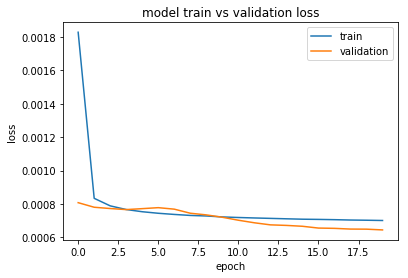

In [8]:
history = model.fit(train_X, train_y, validation_split=0.1, epochs=20, batch_size=32, verbose=1, shuffle=False)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Predicción

In [9]:
p = model.predict(test_X)
prediction = scaler.inverse_transform(p)
real = scaler.inverse_transform(test_y.reshape(-1,1))

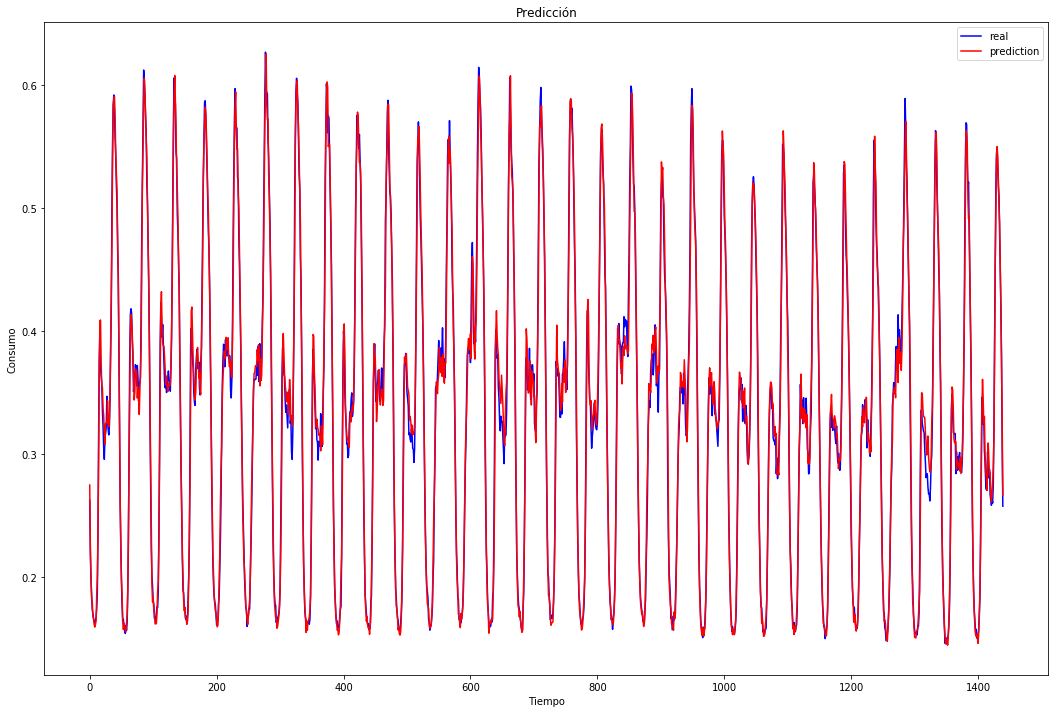

In [10]:
def plot_by_size(real, prediction, t):
    l = len(real)
    plt.figure(figsize=(18, 12))
    plt.title('Predicción')
    plt.xlabel('Tiempo')
    plt.ylabel('Consumo')
    plt.plot(real[l-t:l], color='blue')
    plt.plot(prediction[l-t:l], color='red')
    plt.legend(['real', 'prediction'])
    plt.show()
    
plot_by_size(real, prediction, 48*30) # 1 mes

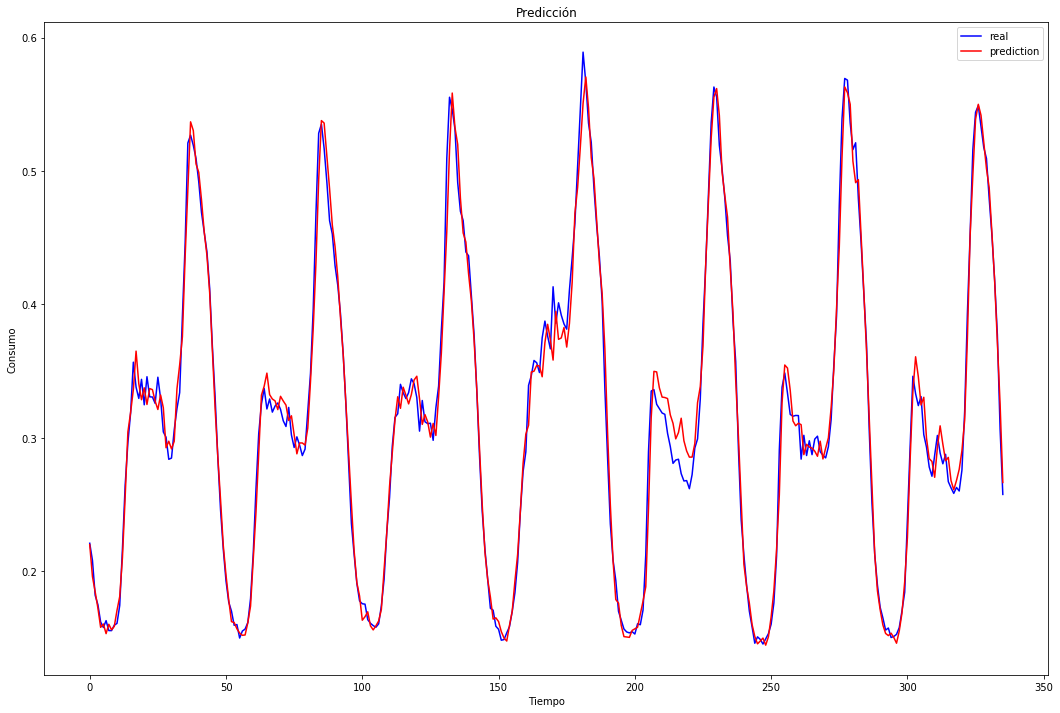

In [11]:
plot_by_size(real, prediction, 48*7) # 1 semana

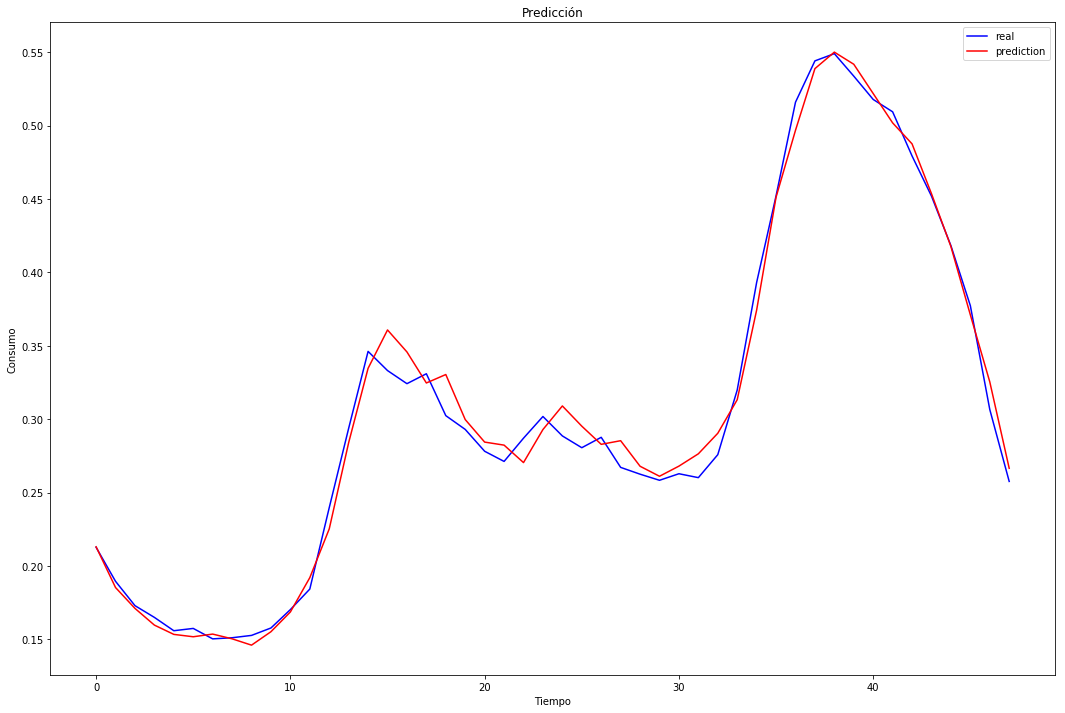

In [12]:
plot_by_size(real, prediction, 48) # 1 dia

## Error

In [13]:
# RMSE: root mean squared error
test_score = math.sqrt(mean_squared_error(real, prediction))
print('Test Score: %.5f RMSE' % test_score)

Test Score: 0.01516 RMSE
